## Implement Quasiparticle Hamiltonian on a Digital Quantum Computer

In [1]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict


Load matrix elements for $^{6}He$

In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]

print(t_onebody)
t_onebody.pop((0,1))
t_onebody.pop((0,2))
t_onebody.pop((1,2))

print(t_onebody)

{(0, 0): -26.722099999999998, (0, 1): 1.0430999999999995, (0, 2): -3.763858685577873, (1, 0): 1.0430999999999995, (1, 1): -26.722099999999998, (1, 2): 3.763858685577873, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -23.4103}
{(0, 0): -26.722099999999998, (1, 0): 1.0430999999999995, (1, 1): -26.722099999999998, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -23.4103}


#### Build-up $H_Q$

In [6]:
def get_hamiltonian(t_onebody:Dict, n_sites:int):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.5*t_val) )
            YY_tuples.append(("YY", [i, j], 0.5*t_val) )
            
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples], num_qubits=n_sites)
    return hamiltonian.simplify()



Get the manybody basis

In [4]:
import numpy as np
from qiskit.quantum_info import Statevector

n_sites=n_qubits
basis_states = [Statevector.from_label(np.binary_repr(i, width=n_sites)) for i in range(2**n_sites)]

bitstring_to_index = {np.binary_repr(i, width=n_sites): i for i in range(2**n_sites)}
index_to_bitstring = {i: np.binary_repr(i, width=n_sites) for i in range(2**n_sites)}

In [5]:
print(index_to_bitstring)

{0: '000', 1: '001', 2: '010', 3: '011', 4: '100', 5: '101', 6: '110', 7: '111'}


In [7]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits)




#### Qiskit has the sick problem that the occupation value 1 becomes 0 (they define $S_z$ in the opposite way). Therefore, to select the Hamiltonian fixed in the one quasiparticle many-body basis we need to consider the conversion to the full bitstrig basis 

bitstring_index= 63- $2^{sp \; index}$

In [12]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_q.to_matrix())[2**(i-1),2**(j-1)]} \n')
        
### We got exactly the same Hamiltonian!

i=0,j=0 ->(-26.7221+0j) 

i=0,j=1 ->(1.0430999999999995+0j) 

i=0,j=2 ->(-3.763858685577873+0j) 

i=1,j=0 ->(1.0430999999999995+0j) 

i=1,j=1 ->(-26.7221+0j) 

i=1,j=2 ->(3.763858685577873+0j) 

i=2,j=0 ->(-3.763858685577873+0j) 

i=2,j=1 ->(3.763858685577873+0j) 

i=2,j=2 ->(-23.410300000000003+0j) 



Build up the total number of particles term

In [7]:
Z_tuples=[("Z", [i], -0.5) for i in range(n_qubits)]
I_tuples=[('I',[i],0.5) for i in range(n_qubits)]
n_operator = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)

print(n_operator.to_matrix())

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j]]


#### Build-up the driver Hamiltonian

In [8]:
coupling_term=-26.7221
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


print(hamiltonian_driver)

SparsePauliOp(['IIZ', 'III'],
              coeffs=[ 13.36105+0.j, -13.36105+0.j])


In [57]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_driver.to_matrix())[2**(i-1),2**(j-1)]} \n')
        

i=0,j=0 ->(-26.7221+0j) 

i=0,j=1 ->0j 

i=0,j=2 ->0j 

i=1,j=0 ->0j 

i=1,j=1 ->0j 

i=1,j=2 ->0j 

i=2,j=0 ->0j 

i=2,j=1 ->0j 

i=2,j=2 ->0j 



#### Let's perform the SUZUKI-TROTTER

In [9]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector


Trotter-Time evolution without noise

In [13]:

#final_state=Statevector(circuit_opt)
time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    for a in range(n_qubits):
        a_mb=2**(a)
        final_state=Statevector(circuit_time_evolution).data
        single_particle_vector[a_mb]=final_state[a_mb]
        psi_for_fidelity[a]=final_state[a_mb]
    energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
final_state=Statevector(circuit_time_evolution)

/tmp/ipykernel_2005726/2772970095.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


In [ ]:
transpiled_circuit_time_evolution.draw()

In [69]:
data=np.load('data/quantum_annealing_pure_qa_6he.npz')

spectrum=data['spectrum']

energy=data['energy']

psi=data['psi_exact']

fidelity=data['fidelity']



In [70]:
fidelity_trotter_clean=psi_for_fidelity.conjugate().dot(psi)*np.conjugate(psi_for_fidelity.conjugate().dot(psi))
print(fidelity_trotter_clean,fidelity)

[0.10810395+8.95974839e-19j] (0.9987340581125074+0j)


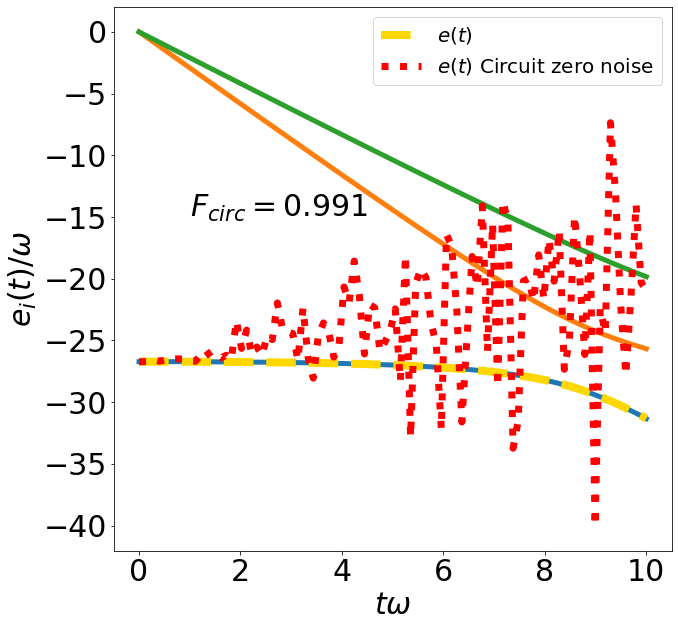

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(3):
    plt.plot(time,spectrum[:,i],linewidth=5)
plt.plot(time,energy,color='gold',linestyle='--',linewidth=8,label=r'$e(t)$')
plt.plot(time,energies_qiskit,color='red',linestyle=':',linewidth=7,label=r'$e(t)$ Circuit zero noise')
plt.tick_params(labelsize=30)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.text(x=1,y=-15,s=r'$F_{circ}=0.991$',fontsize=30)
plt.ylabel(r'$e_i(t)/\omega$',fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [46]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 2381
             Gate count: 3569
    Nonlocal gate count: 1188
         Gate breakdown: RZ: 1191, H: 1190, CX: 1188




#### Analysis of the Annealing with tunable noise

Imports

In [16]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix,state_fidelity
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

transpiled_circuit_time_evolution.save_density_matrix()

Only Depolarization CX

In [17]:

cx_error_rates=10**np.linspace(-5,-1,40)
infidelity=[]
energies_vs_noise=[]
conservation_check=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()

    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    #rz_depol = depolarizing_error(1e-5, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    #h_depol = depolarizing_error(1e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    #noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')


    # Add thermal relaxation errors
    # thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    # for gate in ['sx', 'rz', 'x']:
    #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise.append(eng_tau)
    infidelity.append(1-f_tau)
    conservation_check.append(n_conservation)

energies_vs_noise=np.asarray(energies_vs_noise)
infidelity=np.asarray(infidelity)
conservation_check=np.asarray(conservation_check)

0.009196999920807358
(-31.384691588114556+1.938274591625885e-14j) 

0.01163020805856485
(-31.398094006357717+7.679968532677274e-15j) 

0.014701557414628641
(-31.41503206290414+1.927196436789292e-14j) 

0.018575049138494615
(-31.436426867141577-9.208102266628349e-15j) 

0.02345481842859043
(-31.463432505160718+3.64225961950414e-15j) 

0.029593743630149105
(-31.497490740778446+8.598033977124346e-15j) 

0.03730315537263518
(-31.540395967965345+6.79056203916488e-16j) 

0.04696328196144617
(-31.594370661830716+9.843839935543916e-15j) 

0.059033636161765046
(-31.662150269727647-7.359819753419642e-15j) 

0.07406186069556475
(-31.747074125501378-3.696437770411606e-15j) 

0.09268850532996709
(-31.85317498534853+8.249078698131329e-15j) 

0.11564370874216934
(-31.985253370005438+5.551464701955913e-15j) 

0.14372975478362604
(-32.148913062305915-5.785088905937877e-15j) 

0.17778107648635122
(-32.35051978719597+1.0717660437378931e-14j) 

0.21859096612477014
(-32.597025630196185-6.315951252478921e-1

Adding the one qubit error depolarization

In [18]:
cx_error_rates=10**np.linspace(-5,-1,40)
infidelity_1qerror=[]
energies_vs_noise_1qerror=[]
conservation_check_1qerror=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()

    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    #rz_depol = depolarizing_error(1e-5, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    #noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_depol, 'h')


    # Add thermal relaxation errors
    # thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    # for gate in ['sx', 'rz', 'x']:
    #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_1qerror.append(eng_tau)
    infidelity_1qerror.append(1-f_tau)
    conservation_check_1qerror.append(n_conservation)

energies_vs_noise_1qerror=np.asarray(energies_vs_noise_1qerror)
infidelity_1qerror=np.asarray(infidelity_1qerror)
conservation_check_1qerror=np.asarray(conservation_check_1qerror)

0.13104730160552047
(-31.813062375902387+1.1878180618556495e-14j) 

0.13312428373919782
(-31.825764936484866-6.387154686458015e-15j) 

0.13574603346117797
(-31.84181796572461-3.187213753872876e-15j) 

0.13905258598633186
(-31.862094007071+8.918723703145756e-15j) 

0.14321826442146568
(-31.887686101969493-2.749280559453661e-16j) 

0.14845904648337682
(-31.919959443120035+3.4572329402974426e-15j) 

0.1550408805264848
(-31.960612633620237-2.1514576034114934e-15j) 

0.16328864584398772
(-32.01174872694143-3.899955720567215e-15j) 

0.17359508678732527
(-32.07595495717795+3.494980698289307e-16j) 

0.18642846648695355
(-32.15638779566373+5.252331259113479e-16j) 

0.20233679842666963
(-32.256856146816226+7.285397893039876e-16j) 

0.22194523787757725
(-32.38188936765985-8.711877974699708e-16j) 

0.2459415066781372
(-32.5367674404336-7.117186133633625e-15j) 

0.275042174467948
(-32.72747708028472+4.581431927469002e-15j) 

0.3099306233261646
(-32.96053927807621+8.650686446709296e-15j) 

0.3511565

Adding decoherence

In [ ]:
cx_error_rates=10**np.linspace(-5,-1,40)
infidelity_dec=[]
energies_vs_noise_dec=[]
conservation_check_dec=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()
    t1 = 220.96 * 1e3  # 225.54 us to ns
    t2 = 132.35 * 1e3  # 183.22 us to ns
    gate_time=68
    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    #rz_depol = depolarizing_error(1e-5, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    #noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_depol, 'h')


    # Add thermal relaxation errors
    thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    for gate in ['h', 'rz', 'x']:
        noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_dec.append(eng_tau)
    infidelity_dec.append(1-f_tau)
    conservation_check_dec.append(n_conservation)

energies_vs_noise_dec=np.asarray(energies_vs_noise_dec)
infidelity_dec=np.asarray(infidelity_dec)
conservation_check_dec=np.asarray(conservation_check_dec)

0.8743021821897765
(-38.1500220823865+4.712680832754929e-17j) 



0.87444580150831
(-38.20466203371204-6.506770855148831e-17j) 



0.8745572539200899
(-38.247982759315526+3.131877682450844e-18j) 



0.8746438684329655
(-38.28229519110795-1.2778614040342475e-17j) 



0.8747113642840469
(-38.309497810554944+1.307201281805738e-18j) 



0.874764144415356
(-38.33111899787252+2.5928916446522037e-18j) 



0.874805558380384
(-38.34835205474186-4.796906746893145e-19j) 

0.8748381230884127
(-38.36209957045565+1.9315550017332694e-18j) 



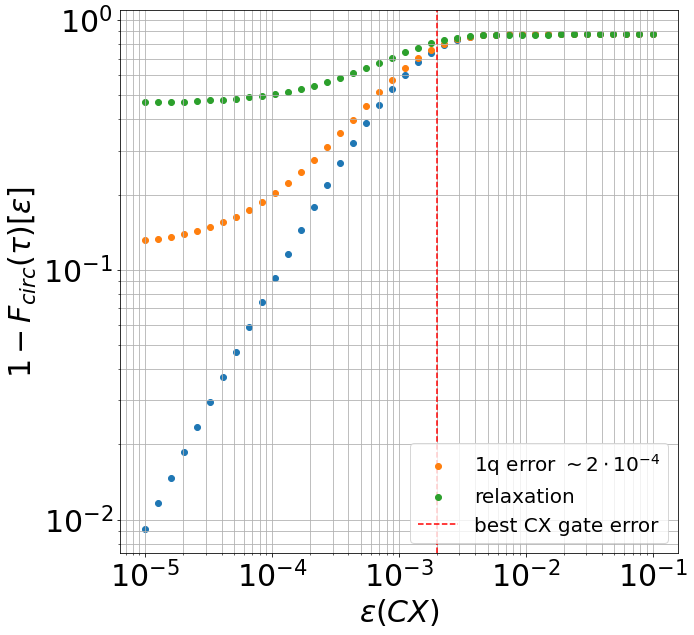

In [20]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,infidelity)
plt.scatter(cx_error_rates,infidelity_1qerror,label='1q error $\sim 2 \cdot 10^{-4}$')
plt.scatter(cx_error_rates,infidelity_dec,label='relaxation')
plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$1-F_{circ}(\tau)[\epsilon]$',fontsize=30)

plt.show()

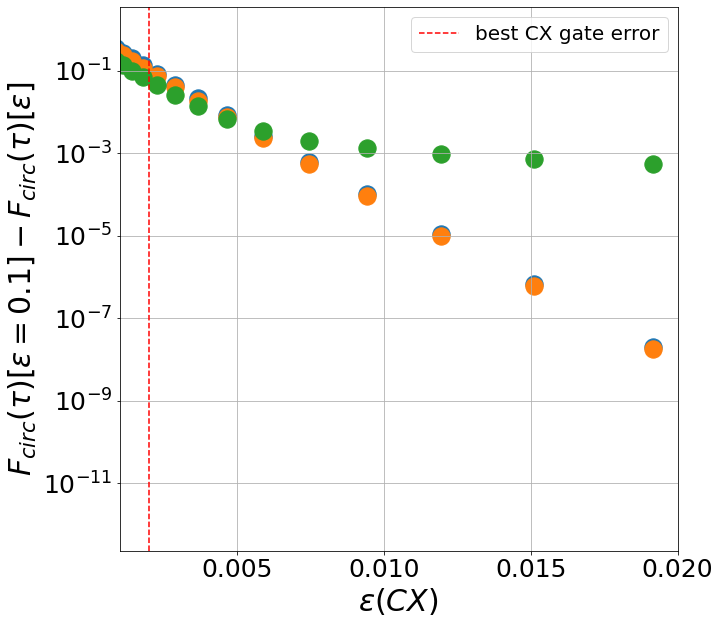

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,infidelity[-1]-infidelity+10**-12,s=300)
plt.scatter(cx_error_rates,infidelity_1qerror[-1]-infidelity_1qerror+10**-12,s=300)
plt.scatter(cx_error_rates,infidelity_dec[-1]-infidelity_dec+10**-12,s=300)
plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.semilogy()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=25)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.xlim([1*10**-3,0.02])
plt.ylabel(r'$F_{circ}(\tau)[\epsilon=0.1]-F_{circ}(\tau)[\epsilon]$',fontsize=30)

plt.show()

Combination of the two plots

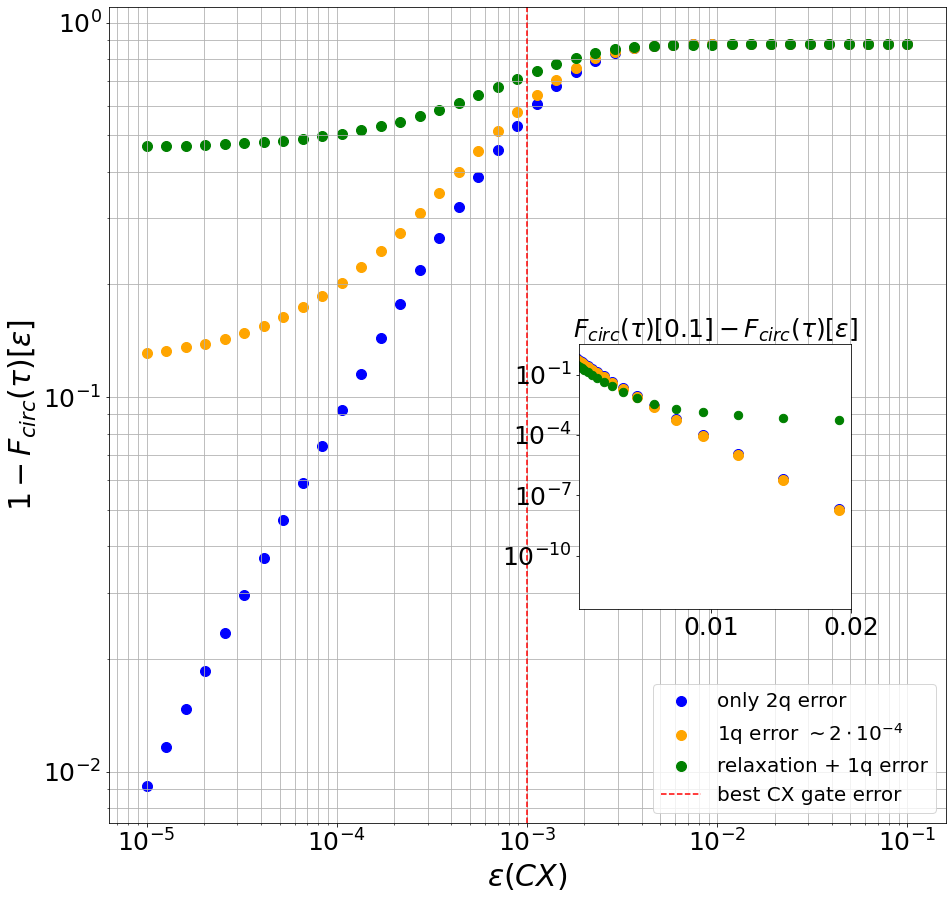

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(15, 15))

# === Main plot: 1 - Fidelity ===
ax.scatter(cx_error_rates, infidelity, color='blue', s=100,label='only 2q error')
ax.scatter(cx_error_rates,infidelity_1qerror,color='orange',label='1q error $\sim 2 \cdot 10^{-4}$',s=100)
ax.scatter(cx_error_rates,infidelity_dec,color='green',label='relaxation + 1q error',s=100)
ax.axvline(x=1e-3, color='red', linestyle='--', label='best CX gate error')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([5e-3, 0.02])
ax.set_xlabel(r'$\epsilon(CX)$', fontsize=30)
ax.set_ylabel(r'$1 - F_{circ}(\tau)[\epsilon]$', fontsize=30)
ax.tick_params(labelsize=25)
ax.grid(True, which='both')
ax.legend(fontsize=20)

# === Inset plot: Fidelity difference ===
ax_inset = inset_axes(
    ax,
    width="65%", height="65%",
    bbox_to_anchor=(0.55, 0.25, 0.5, 0.5),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    loc='lower left', borderpad=1
)

y_diff = infidelity[-1] - infidelity + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='blue', s=100)
y_diff = infidelity_1qerror[-1] - infidelity_1qerror + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='orange', s=100)
y_diff = infidelity_dec[-1] - infidelity_dec + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='green', s=70)
# ax_inset.set_xscale('log')
# ax_inset.set_yscale('log')
ax_inset.set_xlim([5e-4, 0.02])
ax_inset.tick_params(labelsize=25)
ax_inset.tick_params(labelsize=25,which='minor')
ax_inset.semilogy()
ax_inset.set_title(r'$F_{circ}(\tau)[0.1] - F_{circ}(\tau)[\epsilon]$', fontsize=25)
ax_inset.semilogy()
plt.show()

-31.33148916604442 (-31.384691588114556+1.938274591625885e-14j)


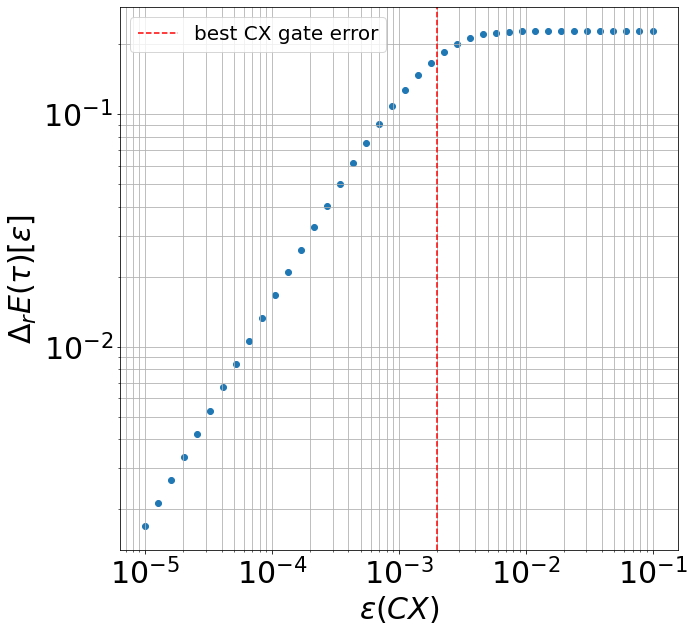

In [23]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))
print(energy[-1],energies_vs_noise[0])
de=np.abs((energies_vs_noise-energy[-1])/energy[-1])
plt.scatter(cx_error_rates,de)

plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$\Delta_r E(\tau)[\epsilon]$',fontsize=30)

plt.show()

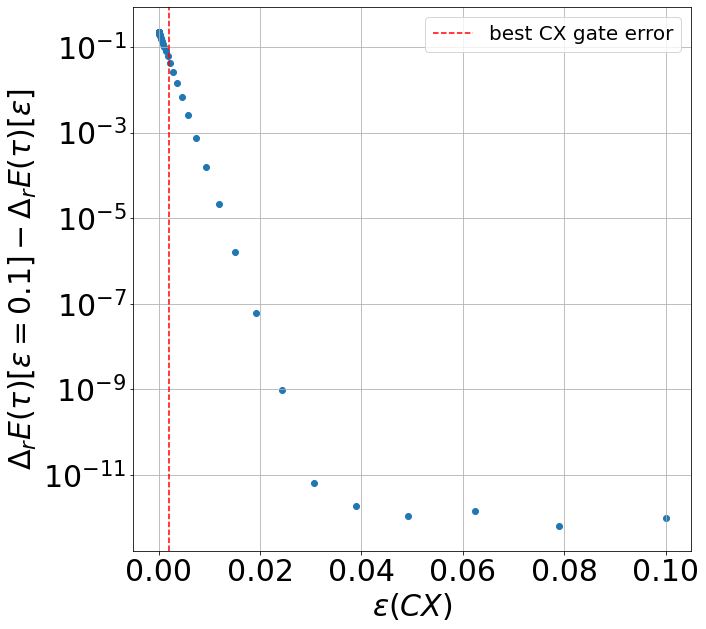

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,de[-1]-de+10**-12)

plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.semilogy()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$\Delta_r E(\tau)[\epsilon=0.1]-\Delta_r E(\tau)[\epsilon]$',fontsize=30)

plt.show()

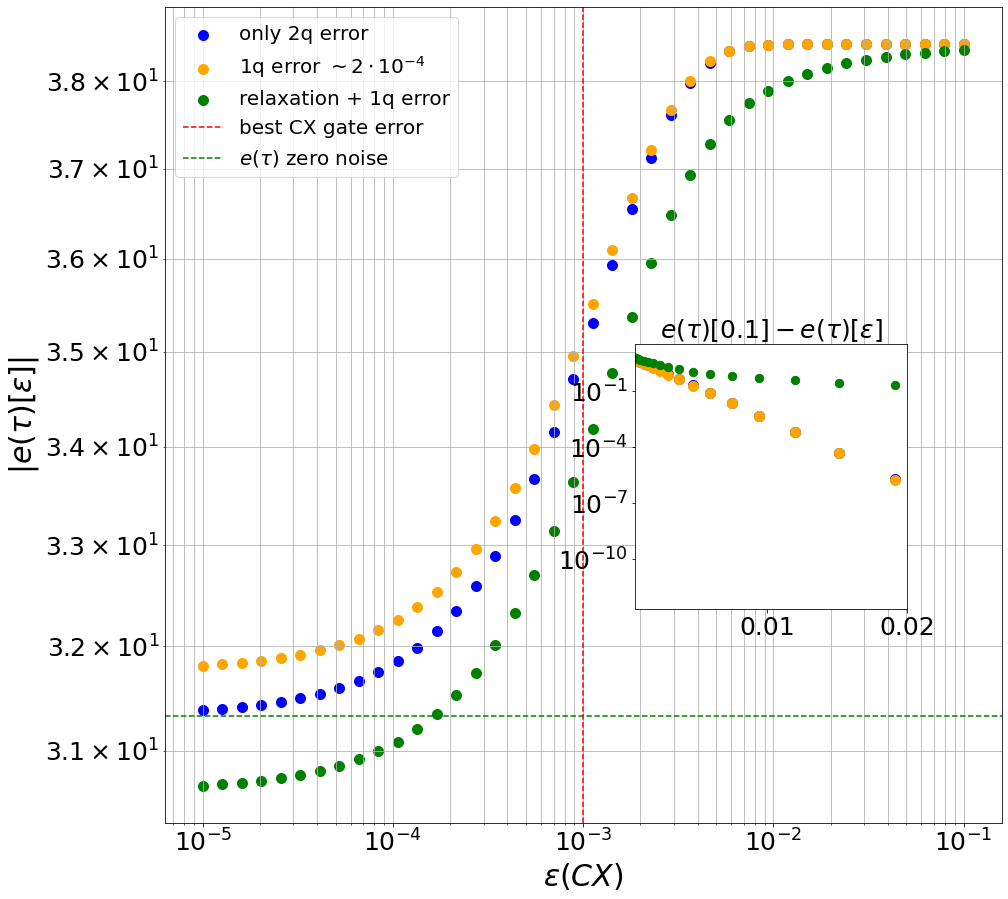

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(15, 15))

# === Main plot: 1 - Fidelity ===
ax.scatter(cx_error_rates, np.abs(energies_vs_noise), color='blue' , s=100,label='only 2q error')
ax.scatter(cx_error_rates, np.abs(energies_vs_noise_1qerror), color='orange', label='1q error $\sim 2 \cdot 10^{-4}$', s=100)
ax.scatter(cx_error_rates, np.abs(energies_vs_noise_dec), color='green', label='relaxation + 1q error', s=100)
ax.axvline(x=1e-3, color='red', linestyle='--', label='best CX gate error')
#ax.set_xscale('log')
#ax.set_yscale('log')2
#ax.set_xlim([5e-3, 0.02])
ax.loglog()
ax.set_xlabel(r'$\epsilon(CX)$', fontsize=30)
ax.set_ylabel(r'$|e(\tau)[\epsilon]|$', fontsize=30)
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25,which='minor')
ax.axhline(y=np.abs(energy[-1]), label=r'$e(\tau)$ zero noise',linestyle='--',color='green')
ax.grid(True, which='both')
ax.legend(fontsize=20)

# === Inset plot: Fidelity difference ===
ax_inset = inset_axes(
    ax,
    width="65%", height="65%",
    bbox_to_anchor=(0.55, 0.25, 0.5, 0.5),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    loc='lower left', borderpad=1
)

y_diff = np.abs(energies_vs_noise[-1] - energies_vs_noise) + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='blue', s=100)
y_diff = np.abs(energies_vs_noise_1qerror[-1] - energies_vs_noise_1qerror) + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='orange', s=100)
y_diff = np.abs(energies_vs_noise_dec[-1] - energies_vs_noise_dec) + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='green', s=70)
# ax_inset.set_xscale('log')
# ax_inset.set_yscale('log')
ax_inset.set_xlim([5e-4, 0.02])
ax_inset.tick_params(labelsize=25)
ax_inset.tick_params(labelsize=25,which='minor')
ax_inset.semilogy()
ax_inset.set_title(r'$  e(\tau)[0.1] -  e(\tau)[\epsilon]$', fontsize=25)
ax_inset.semilogy()

plt.show()

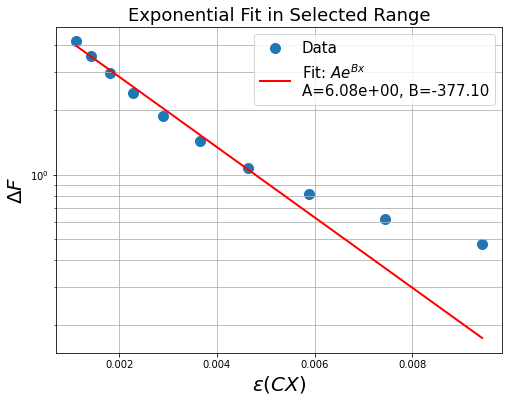

In [30]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Prepare data
x = np.array(cx_error_rates)
y = np.abs(energies_vs_noise_dec[-1] - energies_vs_noise_dec) + 1e-12

# Select range
mask = (x >= 1e-3) & (x <= 1e-2)
x_fit = x[mask]
y_fit = y[mask]

# Define exponential model: y = A * exp(B * x)
def exp_model(x, A, B):
    return A * np.exp(B * x)

# Fit the model
popt, pcov = curve_fit(exp_model, x_fit, y_fit, p0=(1e-3, -100))  # initial guess

A_fit, B_fit = popt

# Generate smooth curve for plotting
x_smooth = np.linspace(min(x_fit), max(x_fit), 300)
y_smooth = exp_model(x_smooth, *popt)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_fit, y_fit, label='Data', s=100)
plt.plot(x_smooth, y_smooth, label=fr'Fit: $A e^{{B x}}$' + f'\nA={A_fit:.2e}, B={B_fit:.2f}', color='red', linewidth=2)
plt.xlabel(r'$\epsilon(CX)$', fontsize=20)
plt.ylabel(r'$\Delta F$', fontsize=20)
plt.semilogy()
plt.grid(True, which='both')
plt.legend(fontsize=15)
plt.title('Exponential Fit in Selected Range', fontsize=18)
plt.show()

In [31]:
# Predict y values using the fit
y_pred = exp_model(x_fit, *popt)

# Compute R^2
residuals = y_fit - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R^2 = {r_squared:.10f}")

R^2 = 0.9811151309


In [32]:
print(np.abs( (energies_vs_noise[-1]+A_fit)-energy[-1])/energy[-1])

-0.032408081759898386


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


[0.00723151-7.56601601e-16j 0.00829328-2.99786032e-16j
 0.0096346 -7.52277266e-16j 0.01132796+3.59436426e-16j
 0.013464  -1.42174874e-16j 0.01615564-3.35622533e-16j
 0.0195429 -2.65068228e-17j 0.02379842-3.84252318e-16j
 0.02913344+2.87289089e-16j 0.03580384+1.44289707e-16j
 0.04411556-3.22001133e-16j 0.05442796-2.16700312e-16j
 0.06715305+2.25819786e-16j 0.0827473 -4.18361727e-16j
 0.10169138+2.46541891e-16j 0.12445179+1.38011794e-16j
 0.15141731+3.61987324e-16j 0.18280408-5.64507023e-17j
 0.21852767+2.05998245e-16j 0.25805131+1.35896064e-16j
 0.3002401 +2.50931248e-16j 0.34327939+7.65555127e-17j
 0.38474354-6.31989002e-17j 0.42190358-2.29216027e-16j
 0.4523002 +1.45499834e-16j 0.47445808-4.56790614e-17j
 0.48842525-3.59715452e-17j 0.49575574+9.50502036e-17j
 0.4988106 -4.46113637e-17j 0.49976312+7.35511286e-17j
 0.49996944+4.85371503e-17j 0.49999773+4.40871803e-17j
 0.49999992-1.54291053e-17j 0.5       +1.52631220e-16j
 0.5       -2.38111286e-17j 0.5       +2.82281439e-17j
 0.5      

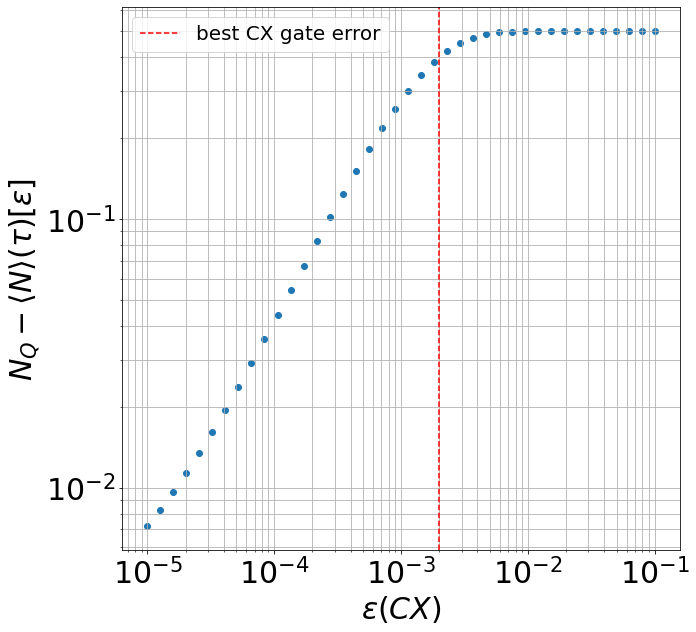

In [206]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))

plt.scatter(cx_error_rates,conservation_check)
print(conservation_check)
plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$N_Q- \langle N \rangle (\tau)[\epsilon]$',fontsize=30)

plt.show()

#### Extrapolate the error

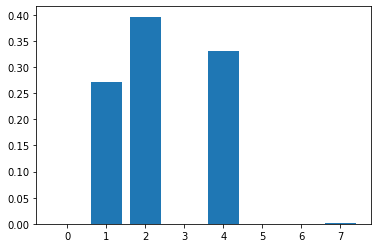

(8,)
(8,)
(8,)


In [30]:
import matplotlib.pyplot as plt



prob=final_state.probabilities()

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

# convert into the single particle state
single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

for a in range(n_qubits):
    a_mb=2**(a)
    print(final_state.data.shape)
    single_particle_vector[a_mb]=final_state.data[a_mb]
single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
final_state_clean_single_particle=Statevector(single_particle_vector)

In [32]:
print(np.linalg.norm(single_particle_vector))
print(np.linalg.norm(final_state.data))
print(final_state.expectation_value(hamiltonian_q))

1.0
0.9999999999999992
(-31.291812300918675+0j)


In [21]:
from qiskit import transpile

# Define your basis gates
custom_basis_gates = ['cz', 'id', 'rz', 'sx', 'x']

# Transpile your circuit using those gates
transpiled_initial_state = transpile(
    initial_state,  # your circuit here
    basis_gates=custom_basis_gates,
    optimization_level=3  # or 0–3 depending on your needs
)

In [ ]:
transpiled_initial_state.draw()

In [166]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_initial_state.depth()}
             Gate count: {len(transpiled_initial_state)}
    Nonlocal gate count: {transpiled_initial_state.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_initial_state.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 427
             Gate count: 709
    Nonlocal gate count: 108
         Gate breakdown: RZ: 272, SX: 264, CZ: 108, X: 65




#### NOISE MODELS

#### Ionq simulator

In [ ]:
import os
from qiskit_ionq import IonQProvider


provider = IonQProvider(token="iNarGLptgimgFldYpwMY5x8mTxRZE1C2")
print(provider.backends())

simulator_backend = provider.get_backend("simulator")
simulator_backend.set_options(noise_model="aria-1")

# Create a basic Bell State circuit:


result = simulator_backend.run(initial_state).result()

# Print the counts


#### Simulation quantum Annealing

In [43]:

#final_state=Statevector(circuit_opt)
time_steps=20
tf=2
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=1.5
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
initial_state.x([0])

for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    initial_state.append(exp_H_t,range(hamiltonian_q.num_qubits))
    
# Define your basis gates
basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
final_state=Statevector(initial_state)

#### IBM ibm_aachen

In [46]:
t1 = 225.54 * 1e3  # 225.54 us to ns
t2 = 183.22 * 1e3  # 183.22 us to ns

gate_time_1q = 50   # estimate for single-qubit gates
gate_time_2q = 350  # estimate for two-qubit gates (CZ, RZZ)

from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import thermal_relaxation_error, depolarizing_error, ReadoutError

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

# Compose with depolarizing error to match median error
sx_error = depolarizing_error(1.840e-4, 1).compose(thermal_1q)
cz_error = depolarizing_error(1.885e-3, 2).compose(thermal_2q)

readout_err = ReadoutError([[1 - 6.836e-3, 6.836e-3], [6.836e-3, 1 - 6.836e-3]])

noise_model = NoiseModel()

for gate in ['sx', 'rx', 'x', 'id']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

# CZ and RZZ are both 2-qubit gates; you can add noise to both or just CZ
noise_model.add_all_qubit_quantum_error(cz_error, 'cz')
noise_model.add_all_qubit_quantum_error(cz_error, 'rzz')


#### IBM Eagle noise

In [45]:
t1 = 230.95 * 1e3  # us to ns
t2 = 129.47 * 1e3  # us to ns

gate_time_1q = 50    # ns, estimate for SX, RZ, X gates
gate_time_2q = 300   # ns, estimate for ECR gate


from qiskit_aer.noise.errors import thermal_relaxation_error

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

from qiskit_aer.noise.errors import depolarizing_error

# SX is single-qubit
sx_error = depolarizing_error(2.476e-4, 1).compose(thermal_1q)

# ECR is two-qubit gate
ecr_error = depolarizing_error(7.294e-3, 2).compose(thermal_2q)

from qiskit_aer.noise import NoiseModel

noise_model = NoiseModel()

# Add errors to basis gates
for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

noise_model.add_all_qubit_quantum_error(ecr_error, 'ecr')

##### IBM ibm_kingston parameters

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

# Median calibration data (converted to nanoseconds)
cz_error_rate = 1.911e-3
sx_error_rate = 2.023e-4
readout_error_rate = 8.301e-3
t1 = 284.35e3  # µs -> ns
t2 = 147.16e3  # µs -> ns
gate_time_1q = 35   # ns, typical for SX/RZ/X
gate_time_2q = 200  # ns, rough estimate for CZ

# Create a noise model
noise_model = NoiseModel()

# Add gate errors
cz_depol = depolarizing_error(cz_error_rate, 2)
sx_depol = depolarizing_error(sx_error_rate, 1)
rz_depol = depolarizing_error(1e-5, 1)
x_depol = depolarizing_error(1e-4, 1)

# Add depolarizing errors
noise_model.add_all_qubit_quantum_error(cz_depol, 'cz')
noise_model.add_all_qubit_quantum_error(sx_depol, 'sx')
noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
noise_model.add_all_qubit_quantum_error(x_depol, 'x')

# Add thermal relaxation errors
thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
#trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')

# Add readout error
# ro_error = ReadoutError([
#     [1 - readout_error_rate, readout_error_rate],
#     [readout_error_rate, 1 - readout_error_rate]
# ])
# noise_model.add_all_qubit_readout_error(ro_error)

# You now have a realistic noise model for a Heron r2-class device

##### Kind of IonQ

In [133]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate, HGate, CXGate

# System parameters (choose Aria 1 here)
r1q = 0.00004     # 1-qubit error rate
r2q = 0.00139     # 2-qubit error rate best performance ever

# Create noise model
noise_model = NoiseModel()

# Define one-qubit depolarizing error
one_qubit_error = depolarizing_error(r1q, 1)

# Define two-qubit depolarizing error
two_qubit_error = depolarizing_error(r2q, 2)

# # Add the one-qubit error to all single-qubit gates


# # Add the two-qubit error to all two-qubit gates (like CX)

    
    
# Assume 0.001 single-qubit error, 0.01 two-qubit error
one_q_error = depolarizing_error(r1q, 1)
two_q_error = depolarizing_error(r2q, 2)

# Add to your favorite gates
#noise_model.add_all_qubit_quantum_error(one_q_error, ['u3'])
#noise_model.add_all_qubit_quantum_error(two_q_error, ['cx'])
for gate in ['cx', 'cz', 'swap']:
    noise_model.add_all_qubit_quantum_error(two_qubit_error, gate)
for gate in ['id', 'x', 'y', 'z', 'h', 's', 't', 'rx', 'ry', 'rz', 'u1', 'u2', 'u3']:
    noise_model.add_all_qubit_quantum_error(one_qubit_error, gate)

#### Simulate with noise

In [47]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix

sim = AerSimulator(noise_model=noise_model)
transpiled_initial_state.save_density_matrix()
# Transpile and run
tqc = transpile(transpiled_initial_state, sim,optimization_level=3)
result = sim.run(tqc).result()



In [ ]:
tqc.draw()

In [26]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {tqc.depth()}
             Gate count: {len(tqc)}
    Nonlocal gate count: {tqc.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in tqc.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 390
             Gate count: 624
    Nonlocal gate count: 108
         Gate breakdown: RZ: 228, SX: 172, CZ: 108, X: 65, RX: 50, SAVE_DENSITY_MATRIX: 1




In [49]:
# Get the output state vector or density matrix
from qiskit.quantum_info import DensityMatrix,state_fidelity
dm = result.data(0)['density_matrix']
print(dm.shape)
density_matrix_final_state=DensityMatrix(dm)
print(density_matrix_final_state.expectation_value(hamiltonian_q))

(8, 8)
(-9.697298986072628-1.0604586013184745e-16j)


/tmp/ipykernel_3970436/3824665734.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print(dm.shape)


/tmp/ipykernel_3970436/3999158546.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]


<BarContainer object of 8 artists>

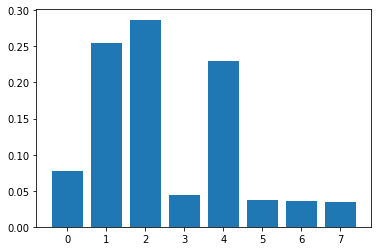

In [50]:
sp_dm=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)
for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]

sp_dm=sp_dm/np.trace(sp_dm)
density_matrix_final_state_single_particle=DensityMatrix(sp_dm)

plt.bar(np.arange(2**n_qubits),density_matrix_final_state.probabilities())

(-2.2363417151214344-3.555536307531051e-32j) 0.6925098050507775


<BarContainer object of 8 artists>

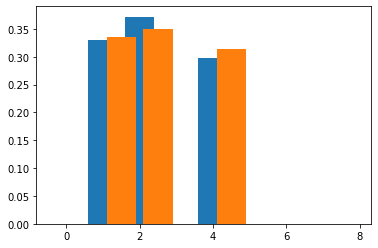

In [51]:
print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q)+7.8,state_fidelity(density_matrix_final_state,final_state_clean_single_particle))

plt.bar(np.arange(2**n_qubits),density_matrix_final_state_single_particle.probabilities())
plt.bar(np.arange(2**n_qubits)+0.5,final_state_clean_single_particle.probabilities())


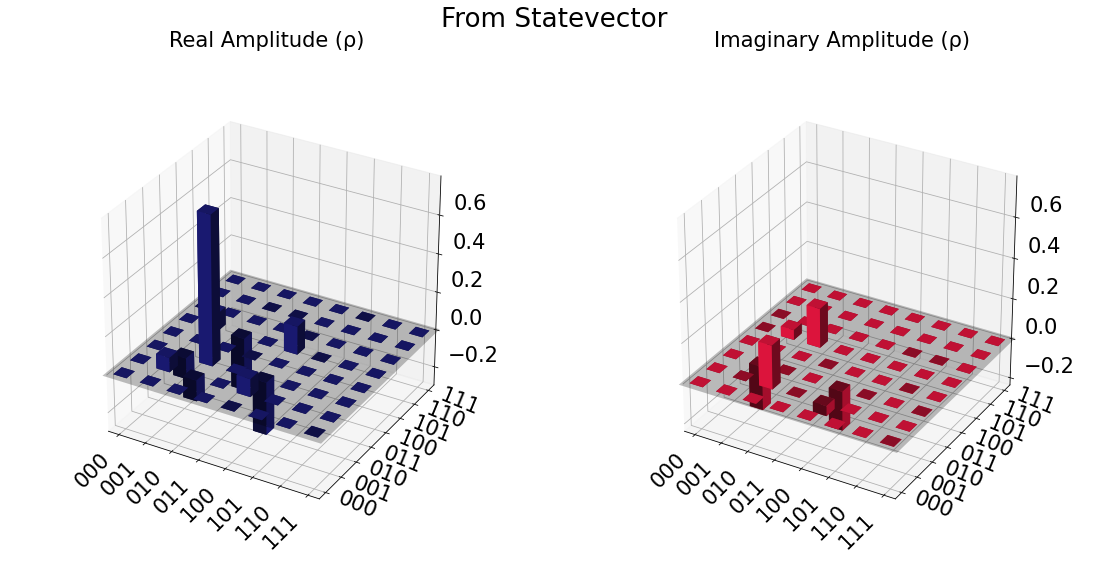

In [174]:
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector, DensityMatrix

from qiskit.visualization import plot_state_city
# Example state
sv = final_state_clean_single_particle              # |+> = (|0> + |1>)/sqrt(2)
dm = density_matrix_final_state_single_particle       # Completely mixed state


# Convert statevector to density matrix
dm_from_sv = DensityMatrix(sv)

# Plot side-by-side city plots (2D bar graphs)
# Plot first density matrix
plot_state_city(dm_from_sv, title="From Statevector", color=['midnightblue', 'crimson'])



# Plot second (possibly noisy) density matrix


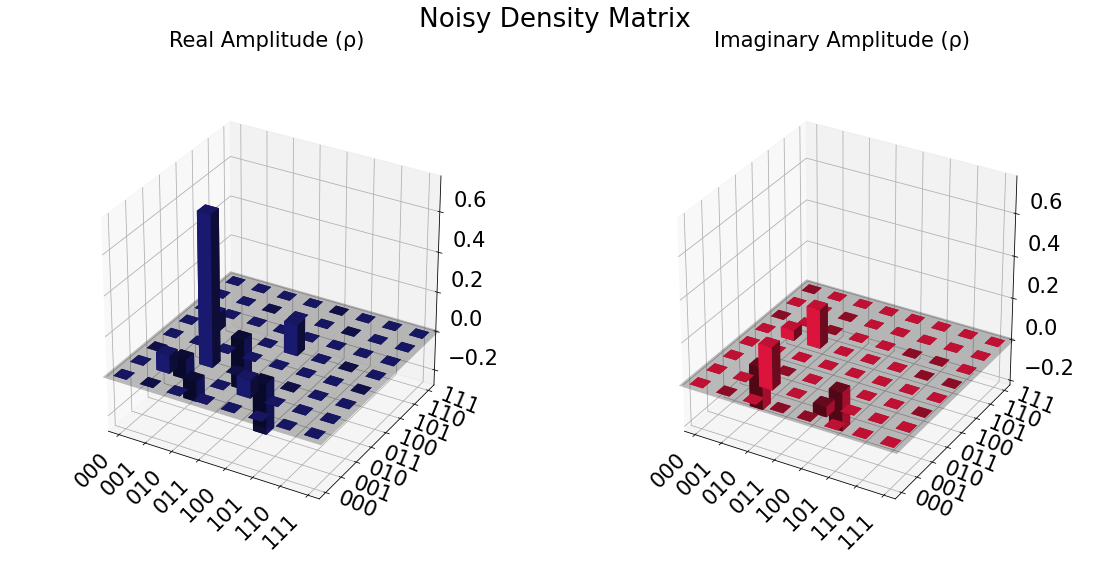

In [175]:
plot_state_city(density_matrix_final_state_single_particle, title="Noisy Density Matrix", color=['midnightblue', 'crimson'])


#### What about quantum optimal control with the time schedule?

In [53]:
class OptimalControlQiskitClean:
    
    def __init__(self,tf,time_steps,n_parameters,hamiltonian_q,hamiltonian_driver):
        
        self.omegas=2*np.pi*np.arange(1,n_parameters+1)*(1+np.random.uniform(-0.5,0.5,n_parameters))/tf
        self.time=np.linspace(0,tf,time_steps)
        self.tf=tf
        self.time_steps=time_steps
        self.parameters=np.zeros(4*n_parameters)
        self.final_psi=None
        self.hamiltonian_q=hamiltonian_q
        self.hamiltonian_driver=hamiltonian_driver
    def energy_quantum_annealing(self,parameters:np.ndarray):
        
        dim=parameters.shape[0]//4
        matrix_driver=(parameters[:dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[dim:2*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))
        matrix_target=(parameters[2*dim:3*dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[3*dim:4*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))

        h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
        h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        
        initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
        initial_state.x([0])
        for n,t in enumerate(time):
            hamiltonian_t=(h_driver[n])*self.hamiltonian_driver+(h_target[n])*self.hamiltonian_q
            exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
            initial_state.append(exp_H_t,range(hamiltonian_t.num_qubits))
            
        
            
        # Define your basis gates
        #basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
        #basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
        basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
        transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
        final_state=Statevector(initial_state)
        
                # convert into the single particle state
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

        for a in range(n_qubits):
            a_mb=2**(a)
            print(final_state.data.shape)
            single_particle_vector[a_mb]=final_state.data[a_mb]
        single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
        final_state_clean_single_particle=Statevector(single_particle_vector)
        self.final_psi=final_state_clean_single_particle
        print(final_state_clean_single_particle.expectation_value(hamiltonian_q).real)
        return final_state_clean_single_particle.expectation_value(hamiltonian_q).real
        
        

In [56]:
class OptimalControlQiskitNoise:
    
    def __init__(self,tf,time_steps,n_parameters,hamiltonian_q,hamiltonian_driver,noise_model):
        
        self.omegas=2*np.pi*np.arange(1,n_parameters+1)*(1+np.random.uniform(-0.5,0.5,n_parameters))/tf
        self.time=np.linspace(0,tf,time_steps)
        self.tf=tf
        self.time_steps=time_steps
        self.parameters=np.zeros(4*n_parameters)
        self.final_psi=None
        self.hamiltonian_q=hamiltonian_q
        self.hamiltonian_driver=hamiltonian_driver
        self.noise_model=noise_model
    def energy_quantum_annealing(self,parameters:np.ndarray):
        
        dim=parameters.shape[0]//4
        matrix_driver=(parameters[:dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[dim:2*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))
        matrix_target=(parameters[2*dim:3*dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[3*dim:4*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))

        self.h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
        self.h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        
        initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
        initial_state.x([0])
        for n,t in enumerate(self.time):
            hamiltonian_t=(self.h_driver[n])*self.hamiltonian_driver+(self.h_target[n])*self.hamiltonian_q
            exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
            initial_state.append(exp_H_t,range(hamiltonian_t.num_qubits))
        
        # Define your basis gates
        #basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
        #basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
        basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
        transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
        
        sim = AerSimulator(noise_model=self.noise_model)
        transpiled_initial_state.save_density_matrix()
        # Transpile and run
        tqc = transpile(transpiled_initial_state, sim,optimization_level=3)
        result = sim.run(tqc).result()
        
        dm = result.data(0)['density_matrix']
        
        sp_dm=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)
        for i in range(1,n_qubits+1):
            for j in range(1,n_qubits+1):
                sp_dm[2**(i-1),2**(j-1)]=np.asarray(dm)[2**(i-1),2**(j-1)]

        sp_dm=sp_dm/np.trace(sp_dm)
        density_matrix_final_state_single_particle=DensityMatrix(sp_dm)
        self.density_matrix_single_particle=density_matrix_final_state_single_particle
        print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q).real)
        self.parameters=parameters
        return density_matrix_final_state_single_particle.expectation_value(hamiltonian_q).real


In [57]:
from scipy.optimize import minimize

OCQ=OptimalControlQiskitNoise(tf=2,time_steps=20,n_parameters=10,hamiltonian_q=hamiltonian_q,hamiltonian_driver=hamiltonian_driver,noise_model=noise_model)

res = minimize(
                    OCQ.energy_quantum_annealing,
                    OCQ.parameters,
                    method='L-BFGS-B',
                    tol=10**-3,
                    options=None,
                    
                )

OCQ.parameters = res.x
energy = OCQ.energy_quantum_annealing(OCQ.parameters)
print(energy)
print(OCQ.parameters)


-10.03634171512143
-10.034191381818019
-10.034666983905876
-10.034441619496691
-10.033681515269558
-10.036341715105895
-10.033895148598972
-10.037616381884284
-10.033704669717858
-10.03604515643687
-10.033518578312774
-10.035941227510499
-10.034440914286034
-10.033298432730454
-10.034440895201666
-10.036045766411911
-10.034667042666078
-10.037616381883936
-10.034439819141486
-10.03518702280973
-10.034667012701188
-10.034441236536434
-10.036270990310296
-10.036341715188303
-10.034440950512229
-10.034435757717027
-10.036341715135078
-10.036040588851431
-10.035941227997926
-10.036270994406141
-10.034666987873306
-10.037616381844986
-10.037616381787014
-10.035941228165306
-10.034441158260679
-10.034665687994764
-10.036045184325824
-10.036044568476504
-10.037616381888405
-10.037616381884877
-10.036045296602033
-10.024734356247944
-10.026341526445286
-10.024509575090237
-10.02371646721075
-10.024734566217862
-10.024734388277043
-10.025929826882612
-10.027675677935262
-10.027675677935033
-10.

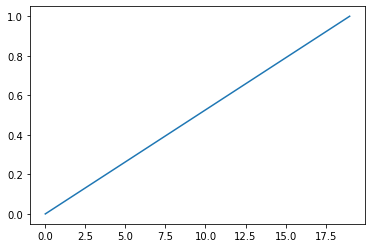

In [42]:
plt.plot(OCQ.h_target)
plt.show()

#### Run on a IBM machine

In [9]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector

#final_state=Statevector(circuit_opt)
time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
print(Statevector(circuit_time_evolution).expectation_value(hamiltonian_q))
transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])

(-31.334163248207602+0j)


In [12]:
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke,FakeMarrakesh,FakeValenciaV2,FakeTorino
from qiskit_aer import StatevectorSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_experiments.test import PulseBackend
# Replace with your actual API token
# service = IBMProvider(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
# backends = service.backends()
# for backend in backends:
#     print(backend.name)
    

    
# # Load the service
# #service = QiskitRuntimeService(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
backend = FakeTorino()
# backend = service.get_backend("ibm_brisbane")

# service = QiskitRuntimeService()
# backend = service.least_busy(
#     operational=True, simulator=False, min_num_qubits=127
# )

# print(backend)
#backend=StatevectorSimulator()
 
estimator = Estimator(mode=backend)
options = estimator.options
# Turn on gate twirling.
options.twirling.enable_gates = True
options.twirling.num_randomizations = 60
options.twirling.shots_per_randomization = 100
options.resilience.pec_mitigation = True
options.resilience.pec_mitigation = True
# #options.resilience.pec.max_overhead = 300
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XpXm"

# options.resilience.zne_mitigation = True
# options.resilience.zne.noise_factors = (1, 2, 3,4,5,6)
# options.resilience.zne.extrapolator = "exponential"
# estimator.options.resilience.zne.amplifier = "pea"


pm = generate_preset_pass_manager(backend=backend, optimization_level=3)



transpiled_qc=pm.run(transpiled_circuit_time_evolution)
layout = transpiled_qc.layout

h_squared=(hamiltonian_q @ hamiltonian_q).simplify()
observables = [
    hamiltonian_q
]
observables = [
    [observable.apply_layout(layout) for observable in observable_set]
    for observable_set in observables
]


estimator_pub = (transpiled_qc ,observables)

transpiled_qc.draw()

#print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


job = estimator.run([estimator_pub])
result = job.result()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'pec_mitigation': True}, 'twirling': {'enable_gates': True, 'num_randomizations': 60, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [13]:

import matplotlib.pyplot as plt 
from qiskit.visualization import plot_histogram
%matplotlib inline

print(np.sum(result[0].data.evs))

-37.79197246071122
